In [34]:
import os
#list the current work dir
os.getcwd()

'/Users/joeljohnson/Desktop/Joel/mediapipe-facemesh'

In [35]:
import mediapipe as mp

In [36]:
import matplotlib.pyplot as plt
import os
import json
import cv2
import numpy as np
import mediapipe as mp
import skimage
from skimage.transform import PiecewiseAffineTransform, warp

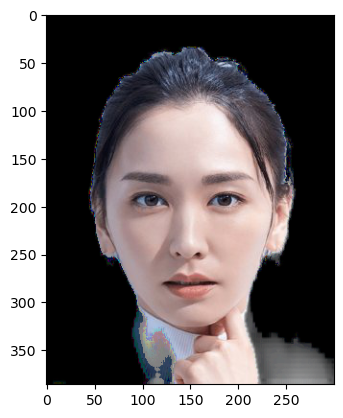

In [37]:
img_path2 = "/Users/joeljohnson/Desktop/Joel/mediapipe-facemesh/data/gakki.jpg"
img_ori = skimage.io.imread(img_path2)

mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

RGB = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
# get the result
results = selfie_segmentation.process(RGB)
# extract segmented mask
mask = results.segmentation_mask
# apply mask to the original image
mask = np.stack((mask,)*3, axis=-1)
mask = mask * 255
mask = mask.astype(np.uint8)
# apply mask to the original image
masked_image = cv2.bitwise_and(img_ori, mask)
# save the result
plt.imshow(masked_image)
plt.show()

In [38]:
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    return ax

uv_path = "./data/uv_map.json" #taken from https://github.com/spite/FaceMeshFaceGeometry/blob/353ee557bec1c8b55a5e46daf785b57df819812c/js/geometry.js
uv_map_dict = json.load(open(uv_path))
uv_map = np.array([ (uv_map_dict["u"][str(i)],uv_map_dict["v"][str(i)]) for i in range(468)])

In [55]:
# borrowed from https://github.com/YadiraF/DECA/blob/f84855abf9f6956fb79f3588258621b363fa282c/decalib/utils/util.py
def load_obj(obj_filename):
    """ Ref: https://github.com/facebookresearch/pytorch3d/blob/25c065e9dafa90163e7cec873dbb324a637c68b7/pytorch3d/io/obj_io.py
    Load a mesh from a file-like object.
    """
    with open(obj_filename, 'r') as f:
        lines = [line.strip() for line in f]

    verts, uvcoords = [], []
    faces, uv_faces = [], []
    # startswith expects each line to be a string. If the file is read in as
    # bytes then first decode to strings.
    if lines and isinstance(lines[0], bytes):
        lines = [el.decode("utf-8") for el in lines]

    for line in lines:
        tokens = line.strip().split()
        if line.startswith("v "):  # Line is a vertex.
            vert = [float(x) for x in tokens[1:4]]
            if len(vert) != 3:
                msg = "Vertex %s does not have 3 values. Line: %s"
                raise ValueError(msg % (str(vert), str(line)))
            verts.append(vert)
        elif line.startswith("vt "):  # Line is a texture.
            tx = [float(x) for x in tokens[1:3]]
            if len(tx) != 2:
                raise ValueError(
                    "Texture %s does not have 2 values. Line: %s" % (str(tx), str(line))
                )
            uvcoords.append(tx)
        elif line.startswith("f "):  # Line is a face.
            # Update face properties info.
            face = tokens[1:]
            face_list = [f.split("/") for f in face]
            for vert_props in face_list:
                # Vertex index.
                faces.append(int(vert_props[0]))
                if len(vert_props) > 1:
                    if vert_props[1] != "":
                        # Texture index is present e.g. f 4/1/1.
                        uv_faces.append(int(vert_props[1]))

    verts = np.array(verts)
    uvcoords = np.array(uvcoords)
    faces = np.array(faces); faces = faces.reshape(-1, 3) - 1
    uv_faces = np.array(uv_faces); uv_faces = uv_faces.reshape(-1, 3) - 1
    
    return (
        verts,
        uvcoords,
        faces,
        uv_faces
    )

# borrowed from https://github.com/YadiraF/DECA/blob/f84855abf9f6956fb79f3588258621b363fa282c/decalib/utils/util.py
def write_obj(obj_name,
              vertices,
              faces,
              texture_name = "texture.jpg",
              colors=None,
              texture=None,
              uvcoords=None,
              uvfaces=None,
              inverse_face_order=False,
              normal_map=True,
              ):
    ''' Save 3D face model with texture. 
    Ref: https://github.com/patrikhuber/eos/blob/bd00155ebae4b1a13b08bf5a991694d682abbada/include/eos/core/Mesh.hpp
    Args:
        obj_name: str
        vertices: shape = (nver, 3)
        colors: shape = (nver, 3)
        faces: shape = (ntri, 3)
        texture: shape = (uv_size, uv_size, 3)
        uvcoords: shape = (nver, 2) max value<=1
    '''
    if os.path.splitext(obj_name)[-1] != '.obj':
        obj_name = obj_name + '.obj'
    mtl_name = obj_name.replace('.obj', '.mtl')
    texture_name
    material_name = 'FaceTexture'

    faces = faces.copy()
    # mesh lab start with 1, python/c++ start from 0
    faces += 1
    if inverse_face_order:
        faces = faces[:, [2, 1, 0]]
        if uvfaces is not None:
            uvfaces = uvfaces[:, [2, 1, 0]]

    # write obj
    with open(obj_name, 'w') as f:
        # first line: write mtlib(material library)
        # f.write('# %s\n' % os.path.basename(obj_name))
        # f.write('#\n')
        # f.write('\n')
        if texture is not None:
            f.write('mtllib %s\n\n' % os.path.basename(mtl_name))

        # write vertices
        if colors is None:
            for i in range(vertices.shape[0]):
                f.write('v {} {} {}\n'.format(vertices[i, 0], vertices[i, 1], vertices[i, 2]))
        else:
            for i in range(vertices.shape[0]):
                f.write('v {} {} {} {} {} {}\n'.format(vertices[i, 0], vertices[i, 1], vertices[i, 2], colors[i, 0], colors[i, 1], colors[i, 2]))

        # write uv coords
        if texture is None:
            for i in range(faces.shape[0]):
                f.write('f {} {} {}\n'.format(faces[i, 2], faces[i, 1], faces[i, 0]))
        else:
            for i in range(uvcoords.shape[0]):
                f.write('vt {} {}\n'.format(uvcoords[i,0], uvcoords[i,1]))
            f.write('usemtl %s\n' % material_name)
            # write f: ver ind/ uv ind
            uvfaces = uvfaces + 1
            for i in range(faces.shape[0]):
                f.write('f {}/{} {}/{} {}/{}\n'.format(
                    #  faces[i, 2], uvfaces[i, 2],
                    #  faces[i, 1], uvfaces[i, 1],
                    #  faces[i, 0], uvfaces[i, 0]
                    faces[i, 0], uvfaces[i, 0],
                    faces[i, 1], uvfaces[i, 1],
                    faces[i, 2], uvfaces[i, 2]
                )
                )
            # write mtl
            with open(mtl_name, 'w') as f:
                f.write('newmtl %s\n' % material_name)
                s = 'map_Kd {}\n'.format(os.path.basename(texture_name)) # map to image
                f.write(s)

                if normal_map is not None:
                    name, _ = os.path.splitext(obj_name)
                    normal_name = f'{name}_normals.png'
                    f.write(f'disp {normal_name}')
                    # out_normal_map = normal_map / (np.linalg.norm(
                    #     normal_map, axis=-1, keepdims=True) + 1e-9)
                    # out_normal_map = (out_normal_map + 1) * 0.5

                    cv2.imwrite(
                        normal_name,
                        # (out_normal_map * 255).astype(np.uint8)[:, :, ::-1]
                        normal_map
                    )
            skimage.io.imsave(texture_name, texture)

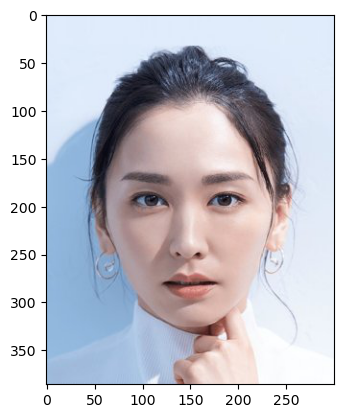

In [77]:
#image source: https://mydramalist.com/people/461-aragaki-yui
img_path = "./data/gakki.jpg"
img_path2 = "/Users/joeljohnson/Desktop/Joel/mediapipe-facemesh/data/gakki.jpg"
img_ori = skimage.io.imread(img_path2)
plt.imshow(img_ori)
plt.show()

ValueError: '[[149.0585357  272.98405099]\n [147.65096605 249.48517418]\n [147.96605408 255.88525569]\n [141.04802012 221.53179002]\n [147.40904868 241.27257025]\n [147.24675715 229.91692638]\n [147.00561762 201.43897367]\n [ 95.43043077 196.77266026]\n [146.50069177 180.00160527]\n [146.23314142 168.82714462]\n [145.2329278  126.08980799]\n [149.16223884 275.5160836 ]\n [149.23296869 278.05444324]\n [149.32233095 279.70336008]\n [149.67998564 284.38573265]\n [149.87375736 287.96197879]\n [150.02608895 292.2700901 ]\n [150.19113421 296.54069936]\n [149.92103577 301.79144657]\n [147.8145808  253.19327569]\n [141.13254547 252.54352391]\n [ 65.38826823 163.18331611]\n [116.74822569 204.58539569]\n [109.06974077 205.10060024]\n [101.74791813 204.6479528 ]\n [ 92.54515171 199.86680949]\n [123.2640624  202.97154212]\n [103.79942358 181.51779246]\n [112.93993592 182.41241193]\n [ 95.79825997 183.0627389 ]\n [ 91.08527899 186.23207629]\n [ 86.25441492 205.17806613]\n [124.95284379 310.92080307]\n [ 92.87622571 194.57989466]\n [ 64.5401448  198.82827878]\n [ 77.72746682 199.30207002]\n [111.73263788 239.43929517]\n [140.71468413 271.31242585]\n [141.91408753 277.67125511]\n [133.00695419 273.98386025]\n [128.00302505 276.5866636 ]\n [135.80015302 278.03421974]\n [131.1005652  278.86135852]\n [117.68248379 287.76814151]\n [141.64272845 249.28425062]\n [140.44897556 241.35479867]\n [ 79.05240655 179.74730456]\n [125.95981658 218.85527098]\n [125.72570443 245.74276865]\n [125.22134185 241.06462944]\n [ 89.69247937 237.79435861]\n [140.64121842 230.7843051 ]\n [ 95.35817206 171.44234896]\n [ 85.29619575 174.14326733]\n [ 71.55173421 149.23135698]\n [129.85778153 178.84718633]\n [120.96573114 186.0083639 ]\n [112.13413775 280.38106585]\n [ 80.36314845 270.75431252]\n [131.29689395 250.34404016]\n [136.8881017  252.53027165]\n [122.02290595 280.6317544 ]\n [123.82086217 280.63274372]\n [ 80.96263111 168.76473707]\n [125.63737035 248.77479792]\n [109.92583036 172.30666769]\n [107.96622634 165.61668152]\n [100.97224116 130.58207047]\n [ 77.13692486 158.63429439]\n [106.21064901 147.66259789]\n [ 74.81910288 175.81483495]\n [ 70.26037574 169.6088438 ]\n [141.15656018 274.873119  ]\n [134.37606096 276.20285428]\n [129.47115004 277.7876265 ]\n [132.98404813 251.55933666]\n [122.95072675 280.6448226 ]\n [125.97724199 282.86388564]\n [124.73115027 280.62936163]\n [134.21453834 248.47583985]\n [132.39612579 279.53759181]\n [137.01100051 279.13629687]\n [142.68246889 279.25936341]\n [140.54566026 301.60435045]\n [141.14652872 295.57682765]\n [141.46455824 291.31944764]\n [142.08007157 287.04490411]\n [142.85882413 283.71373272]\n [132.52630234 281.93243134]\n [131.04611635 283.40343201]\n [129.38509583 285.44807601]\n [128.0482024  287.76708317]\n [119.27467883 268.1407187 ]\n [ 68.25084686 231.90386784]\n [147.89288342 254.49434376]\n [129.06209528 281.3176738 ]\n [127.54113078 282.00322509]\n [139.10669982 255.42786872]\n [128.30007076 252.95800209]\n [138.05088401 254.01256895]\n [118.29259694 223.41713083]\n [106.20511472 228.84636939]\n [124.17417169 244.23293149]\n [ 82.81436563 138.01763421]\n [ 88.52600455 150.87350965]\n [ 92.29483008 164.85246795]\n [123.71333241 293.07449758]\n [126.44249797 167.86446929]\n [124.66387153 147.14035308]\n [121.11127675 126.99282515]\n [ 95.83505988 202.94535971]\n [ 78.47680449 210.87386835]\n [127.4784565  201.24002874]\n [ 84.03373361 189.63344324]\n [130.8843255  213.69726658]\n [129.57928777 243.3469398 ]\n [ 70.9638834  215.68791223]\n [ 83.36634636 217.0260452 ]\n [ 92.84518361 220.48909497]\n [107.40540326 219.40590692]\n [118.1217581  216.17320716]\n [125.92298985 212.52883613]\n [140.05838335 203.34644759]\n [ 73.65809977 232.88750291]\n [ 78.00052464 188.5475173 ]\n [144.16308403 252.95634556]\n [127.05694735 227.43914521]\n [ 62.792328   196.46801937]\n [131.5839529  208.36196721]\n [123.64016175 244.17803586]\n [ 89.46352601 195.00808525]\n [129.29332852 237.64458048]\n [ 73.35929275 250.98863828]\n [127.56282091 198.32020652]\n [134.68801081 233.34859407]\n [ 96.30501866 291.59353471]\n [ 98.09637666 298.33759975]\n [ 68.36355329 232.64693761]\n [ 86.97100282 280.8424561 ]\n [ 66.94671214 183.01288188]\n [124.56112504 316.81499803]\n [145.00504732 254.23127723]\n [120.56635916 233.12146509]\n [ 72.09179699 200.40384805]\n [102.30225921 199.6147635 ]\n [108.65465999 200.34004855]\n [124.55930114 283.92438841]\n [ 77.1071434  248.65497541]\n [137.39709556 325.58686566]\n [117.61302352 315.43377221]\n [108.88301432 308.496261  ]\n [145.69889903 147.29834485]\n [151.37402415 326.82813752]\n [115.17557502 199.98398614]\n [121.39600217 199.12199116]\n [125.53001046 198.807181  ]\n [ 73.16831052 186.56113952]\n [120.2027142  192.08706665]\n [113.29292357 189.52879411]\n [106.46579862 188.99363065]\n [100.05941391 190.13706356]\n [ 96.37160897 191.974549  ]\n [ 62.80077696 178.11952001]\n [ 98.17977548 198.2600652 ]\n [148.18378687 261.74118936]\n [126.00685358 264.15636742]\n [131.21480942 249.30946672]\n [138.62502873 262.17253196]\n [146.77771926 190.30364859]\n [105.96089065 301.64859366]\n [115.09636045 309.16437268]\n [136.46728992 322.42217577]\n [ 88.93960118 286.66516709]\n [125.1965493  195.81129634]\n [135.70326269 216.92248893]\n [151.12196803 323.4278059 ]\n [126.76620483 321.48819065]\n [ 72.96921909 249.97608292]\n [137.18036413 282.76564407]\n [135.76832414 285.2631886 ]\n [134.52177644 288.51822853]\n [133.67253542 292.31306791]\n [131.1896503  298.0607748 ]\n [127.38758326 279.74875367]\n [125.81408322 279.26872742]\n [124.49753881 278.67235279]\n [114.34313357 273.73169923]\n [ 86.26300693 254.14341199]\n [135.55104733 207.94008064]\n [132.05377758 192.02450955]\n [127.95038223 192.93263435]\n [128.81062925 280.09828198]\n [ 88.0826354  271.66766   ]\n [137.73044944 192.01920635]\n [127.74760723 304.3534348 ]\n [147.18334973 220.32873344]\n [140.50963819 212.9619503 ]\n [147.11541831 211.29039419]\n [131.16751313 229.98716795]\n [150.75640082 317.42807603]\n [150.34879446 309.26503003]\n [138.59993219 308.82602596]\n [111.60098612 290.17236805]\n [117.64790118 250.21703935]\n [119.09328103 298.20383477]\n [100.77177286 248.65810442]\n [111.26516461 257.95154965]\n [ 96.02780342 260.75566769]\n [136.74135804 316.69690108]\n [127.35392153 234.21546662]\n [106.68030381 294.78709888]\n [115.92590511 303.09522951]\n [105.41059077 280.77971494]\n [ 80.78332543 261.62686563]\n [ 97.39508629 280.82050705]\n [ 78.52491438 265.94714785]\n [106.48849905 267.64010084]\n [131.50001764 222.03323615]\n [131.93627    247.17675042]\n [128.04509997 248.57187271]\n [134.54428911 242.08657181]\n [125.24268329 184.3091414 ]\n [111.79026067 178.87771714]\n [100.27218461 178.06146085]\n [ 91.33666456 179.87425935]\n [ 85.87651849 183.5896427 ]\n [ 84.35406089 197.08986318]\n [ 65.23138583 215.62818503]\n [ 90.34548998 208.85439444]\n [ 97.94450998 211.50452399]\n [108.1055671  211.63391757]\n [117.7121222  209.90254223]\n [125.0962168  207.47724092]\n [130.07837534 205.02281225]\n [ 64.97761309 213.95361495]\n [128.30144763 250.29965889]\n [135.69833636 224.9733969 ]\n [136.64631844 248.02296233]\n [140.51004052 251.49275327]\n [136.79725528 249.02923667]\n [130.34740984 252.30065787]\n [141.8957144  252.38684356]\n [142.74413288 253.71367991]\n [130.070436   198.75886548]\n [133.72088671 200.62927449]\n [135.59524119 202.12631953]\n [ 94.37273741 193.36538041]\n [ 88.48575354 189.91850483]\n [153.52710485 221.32941699]\n [201.00007653 196.47973013]\n [154.71248031 252.28689945]\n [227.64855623 161.13795888]\n [180.3835094  205.24899793]\n [188.02669644 205.49004638]\n [195.19677758 204.6202749 ]\n [204.05623913 199.02602732]\n [173.66629243 203.70349932]\n [190.28365016 181.09610146]\n [181.28426671 182.48200929]\n [198.59996438 182.11366093]\n [203.87939215 184.9757461 ]\n [210.67909598 203.86956668]\n [176.59310102 310.23746049]\n [203.3737421  193.75409031]\n [231.51637316 196.95379746]\n [218.82365942 197.40729618]\n [185.02020836 238.35550892]\n [157.34120607 271.17884493]\n [156.55388832 277.6046257 ]\n [165.26142955 273.77925551]\n [170.37289739 276.36894464]\n [162.71188259 277.93703651]\n [167.46895909 278.74402082]\n [181.39691949 286.59287786]\n [153.68615985 249.09232295]\n [154.49545383 241.14071488]\n [214.26086426 177.68269014]\n [169.67951059 218.19371641]\n [170.27190328 245.12138498]\n [170.73554993 240.40572071]\n [207.58733153 236.14341712]\n [153.97744775 230.55156231]\n [196.12839818 170.9274205 ]\n [206.85392618 172.69649345]\n [220.61516047 147.29265052]\n [162.50463724 179.53609669]\n [173.79053235 186.55742383]\n [186.48097515 279.06752777]\n [220.99063396 268.95389199]\n [164.79154229 249.84641325]\n [159.22944546 252.20315254]\n [176.81795955 280.5891217 ]\n [175.05270839 280.596277  ]\n [210.64724922 167.18825901]\n [170.57540417 248.15530086]\n [181.69950843 172.55943841]\n [182.60800838 166.09409642]\n [190.06438851 129.43396705]\n [215.48559666 156.95684838]\n [185.52938104 146.68029726]\n [218.4014082  173.6511277 ]\n [223.24923277 167.88873059]\n [157.13962913 274.77595878]\n [164.02816772 276.06823802]\n [169.02349591 277.59997821]\n [163.14711571 251.11600721]\n [175.90631247 280.61268127]\n [173.21993709 282.86197603]\n [174.13423061 280.57899845]\n [161.56795621 248.03863037]\n [166.21314883 279.43725657]\n [161.59266829 279.04948997]\n [155.97336888 279.22204542]\n [159.45589542 301.27920997]\n [159.14826393 295.59958196]\n [158.45655799 291.30350351]\n [157.52216578 287.02725744]\n [156.41553998 283.72569656]\n [166.48811102 281.92214704]\n [168.24259758 283.39765716]\n [170.11726499 285.4601779 ]\n [171.67085409 287.77614808]\n [178.31881642 267.15243614]\n [230.45661449 229.86046624]\n [169.83777881 281.29853165]\n [171.53763771 281.99427521]\n [157.13632107 255.15787697]\n [168.20989251 252.41689122]\n [158.12085271 253.73259199]\n [177.63091922 222.55690742]\n [190.23696184 227.65428734]\n [172.06494212 243.60464561]\n [208.80591273 136.38637555]\n [203.53206396 149.49170864]\n [198.41505289 164.38699389]\n [175.81402659 292.13568091]\n [164.32330012 168.97268939]\n [166.92291498 146.6020031 ]\n [169.53831911 126.3375861 ]\n [200.98782778 202.56175745]\n [219.09595728 209.18475759]\n [169.1345036  202.10789061]\n [211.20252013 187.94987726]\n [164.43428993 213.17423952]\n [166.09116197 242.83040082]\n [225.80291033 213.84278834]\n [214.31846023 215.45809138]\n [204.80550528 219.08856595]\n [190.21112323 218.42261696]\n [179.36022878 215.55410123]\n [171.14676833 212.27922893]\n [154.28193212 203.1460762 ]\n [224.0876019  231.01808321]\n [217.02455878 186.58736795]\n [151.49985552 252.81381476]\n [168.72276664 226.77551997]\n [233.16299915 194.31121433]\n [164.91177678 208.47017097]\n [172.69906998 243.51539993]\n [206.8197906  193.81510592]\n [166.26611352 237.08704233]\n [226.76643133 249.03487349]\n [168.65102649 199.32997799]\n [160.36217809 232.93880939]\n [205.32810688 290.31278217]\n [204.58585024 297.00991213]\n [229.93690968 230.71940124]\n [214.26233053 279.27834451]\n [227.68877149 181.1743381 ]\n [177.69842148 316.19566202]\n [150.79298615 254.11999047]\n [175.58342814 232.31287026]\n [225.28756857 198.30941606]\n [194.31467056 200.27127945]\n [187.9737854  201.34878469]\n [174.75174665 283.8932364 ]\n [221.74748182 246.74082935]\n [165.38711786 325.18890679]\n [185.33526063 314.46888816]\n [194.07740235 307.41560376]\n [181.4809978  201.11466146]\n [175.14204383 200.23686039]\n [170.85658908 199.92773306]\n [222.04872966 184.31473219]\n [175.36307573 192.45409209]\n [181.99991584 189.48700118]\n [188.8764739  188.75473338]\n [195.48135996 189.63630766]\n [199.40716624 191.28192294]\n [231.43876791 175.97633535]\n [198.36539626 198.43913174]\n [171.27299309 263.40453184]\n [164.77586031 248.78524327]\n [158.10542107 261.89961827]\n [195.92891335 300.66136944]\n [187.0413065  308.40057325]\n [165.83785415 322.0827477 ]\n [213.28103542 285.07855427]\n [170.69202662 196.63220012]\n [159.25154686 216.53281271]\n [176.11502409 320.73331809]\n [226.47415996 248.07325649]\n [161.97506189 282.74346495]\n [163.68153691 285.24381638]\n [165.24315476 288.52400339]\n [166.48317575 292.3447721 ]\n [168.63411069 297.30212903]\n [171.37886882 279.61027217]\n [172.86867499 279.1130594 ]\n [174.14274216 278.49100852]\n [183.67313147 272.52668703]\n [212.39461899 252.33726263]\n [159.23395157 207.59851289]\n [163.2230401  192.99486935]\n [167.71591902 193.87994075]\n [169.95037794 279.98950303]\n [211.97887659 269.94882369]\n [156.48812056 192.89564997]\n [173.03461432 303.65285969]\n [153.98578048 212.73153126]\n [164.29921389 229.48489356]\n [162.25104332 308.45721745]\n [188.22160363 289.09957933]\n [179.13390398 249.3115834 ]\n [181.33129478 297.29028022]\n [196.83094025 247.1888063 ]\n [186.26214266 256.77433038]\n [202.5125742  259.15718305]\n [164.88910317 316.35671377]\n [168.48351359 233.5699482 ]\n [194.19050217 293.68186975]\n [185.38997769 302.24084997]\n [193.81928444 279.5291481 ]\n [218.96983981 259.76361191]\n [202.71903276 279.39299035]\n [221.95202708 264.13655806]\n [191.73724651 266.31616342]\n [163.83921504 221.52730358]\n [163.78821731 246.68920076]\n [167.96768904 248.01325321]\n [160.70321202 241.69788492]\n [168.87286305 185.10092932]\n [181.31048083 179.1343646 ]\n [192.64810681 177.57924891]\n [201.94509029 178.70757747]\n [208.23481679 181.98962808]\n [211.9566679  195.53021502]\n [231.93644285 213.71286559]\n [206.82325959 207.76724911]\n [199.33510423 210.72139835]\n [189.27447796 211.2727015 ]\n [179.61348295 209.8735069 ]\n [171.99261189 207.69307327]\n [166.67776108 205.41692889]\n [232.42208362 211.83447301]\n [167.81716347 249.73498845]\n [159.23915505 224.5831455 ]\n [158.81218314 247.6746074 ]\n [155.22640944 251.25860703]\n [158.8655591  248.71355224]\n [165.95753431 251.78605151]\n [153.79990339 252.16914761]\n [153.04990411 253.508569  ]\n [166.18766785 199.70861065]\n [162.43675947 201.30787754]\n [160.07133722 202.66147149]\n [201.59837008 192.5745818 ]\n [207.00405836 188.56953537]]' is not a valid format string (unrecognized character '[')

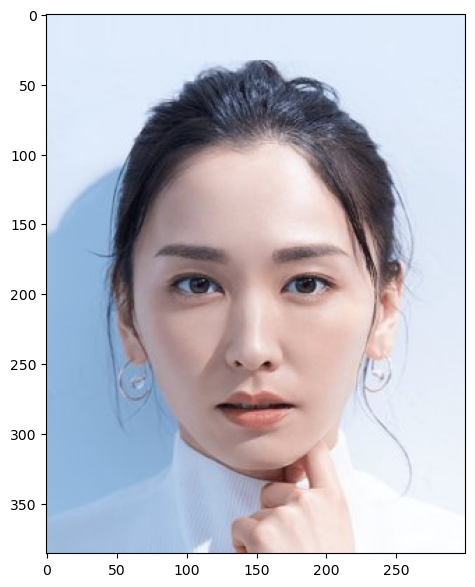

In [78]:
img = img_ori
# img = masked_image
H,W,_ = img.shape
#run facial landmark detection
with mp.solutions.face_mesh.FaceMesh(
        static_image_mode=True,
        refine_landmarks=True,
        max_num_faces=1,
        min_detection_confidence=0.6) as face_mesh:
        results = face_mesh.process(img)

assert len(results.multi_face_landmarks)==1 

face_landmarks = results.multi_face_landmarks[0]
keypoints = np.array([(W*point.x,H*point.y) for point in face_landmarks.landmark[0:468]])#after 468 is iris or something else
ax = imshow(img)
ax.plot(keypoints[:, 0], keypoints[:, 1], '.b', markersize=2)
# ax.plot(face_landmarks.landmark[100].x*W, face_landmarks.landmark[0].y*H, 'or', markersize=5)
plt.show()

/var/folders/c0/9r1vps757pgfst2gn8pz_ggr0000gn/T/ipykernel_35134/225603380.py:5: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  tform.estimate(keypoints_uv,keypoints)


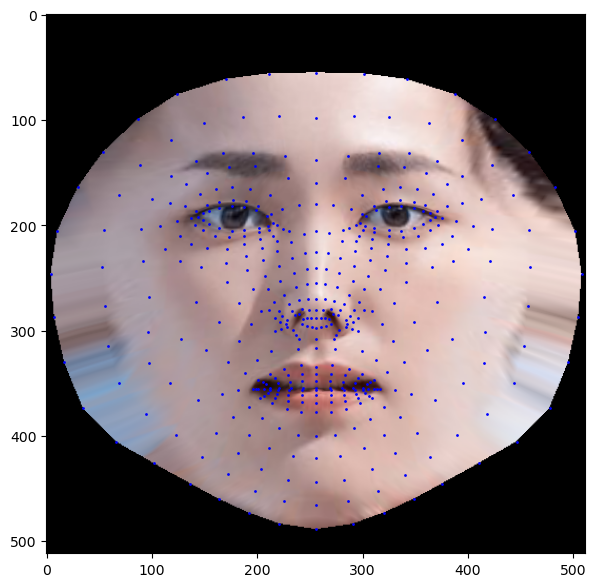

In [42]:
H_new,W_new = 512,512
keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])

tform = PiecewiseAffineTransform()
tform.estimate(keypoints_uv,keypoints)
texture = warp(img_ori, tform, output_shape=(H_new,W_new))
texture = (255*texture).astype(np.uint8)

ax = imshow(texture)
ax.plot(keypoints_uv[:, 0], keypoints_uv[:, 1], '.b', markersize=2)
plt.show()


In [58]:
keypoints3d = np.array([(point.x,point.y,point.z) for point in face_landmarks.landmark[0:468]])

In [59]:
obj_filename = "./data/canonical_face_model.obj"
# obj_filename = "/Users/joeljohnson/Desktop/mediapipe-facemesh/data/head_template.obj"
verts,uvcoords,faces,uv_faces = load_obj(obj_filename)

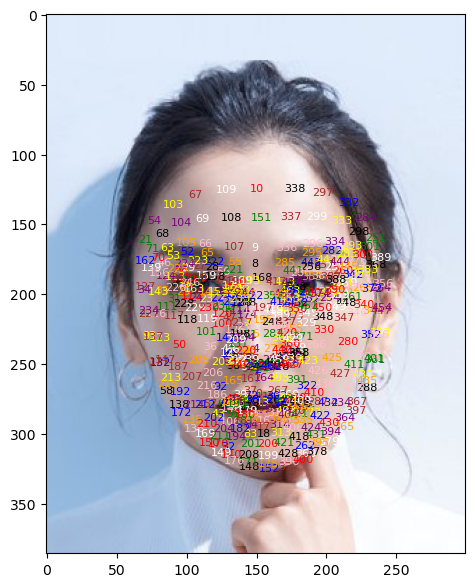

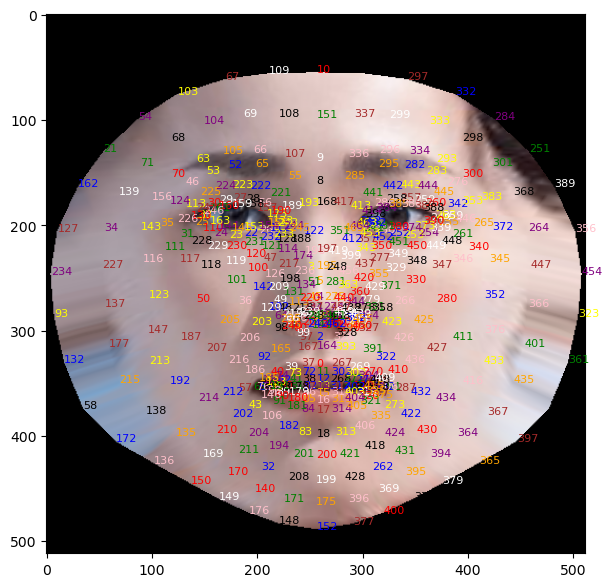

[219 191 187]
[219 191 187]
[172.3 145.7 144.8]
32 [164 140 140] 89.70249439118186
44 [179 145 143] 86.12364657862535
61 [76 48 45] 37.393950045426855
76 [76 48 45] 37.393950045426855
94 [183 140 134] 18.080721777625783
111 [161 135 136] 96.53922777814213
114 [177 146 141] 37.73503014441577
125 [180 145 141] 89.80082126573204
128 [180 147 142] 95.97800529287925
150 [152 126 125] 82.484953173291
182 [161 135 134] 53.89566309082767
189 [140 110 112] 73.0025855706493
201 [175 147 144] 34.32247805738954
202 [174 144 146] 16.51446335791744
218 [177 148 144] 61.75356265026317
220 [168 146 149] 15.326039932090499
227 [159 148 156] 96.3013629187048
247 [148 122 121] 94.7558309551449
296 [177 152 147] 56.834606535103156
373 [176 146 146] 46.53383177861018
380 [177 147 145] 62.466731145466404
381 [174 142 145] 23.540125318272917
442 [181 146 140] 97.57808411728499
447 [241 220 215] 57.00817923771987
454 [240 219 214] 51.876367451854755
[array([168, 146, 149], dtype=uint8), array([174, 144, 146],

/var/folders/c0/9r1vps757pgfst2gn8pz_ggr0000gn/T/ipykernel_35134/169057601.py:47: RuntimeWarning: invalid value encountered in scalar power
  d = sum((2+rm,4,3-rm)*(rgb1-rgb2)**2)**0.5


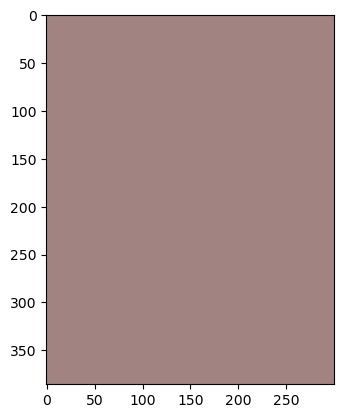

In [76]:
def normalize_keypoints(keypoints3d):
    center = keypoints3d[0]
    keypoints3d = keypoints3d - center
    axis1 = keypoints3d[165] - keypoints3d[391]
    axis2 = keypoints3d[2] - keypoints3d[0]
    axis3 = np.cross(axis2,axis1)
    axis3 = axis3/np.linalg.norm(axis3)
    axis2 = axis2/np.linalg.norm(axis2)
    axis1 = np.cross(axis3, axis2)
    axis1 = axis1/np.linalg.norm(axis1)
    U = np.array([axis3,axis2,axis1])
    keypoints3d = keypoints3d.dot(U)
    keypoints3d = keypoints3d - keypoints3d.mean(axis=0)
    return keypoints3d

vertices = normalize_keypoints(keypoints3d)

# borrowed from https://github.com/YadiraF/PRNet/blob/master/utils/write.py
obj_name =  "./results/obj_model.obj"
# obj_name2 = "/Users/joeljohnson/Desktop/mediapipe-facemesh/data/head_template.obj"
write_obj(obj_name,
              vertices,
              faces,
              texture_name = "./results/texture3.jpg",
              texture=texture,
              uvcoords=uvcoords,
              uvfaces=uv_faces,
              )

#print landmarks with labels on image
ax = imshow(img_ori)
ax2 = imshow(texture)
colors = ['red','green','blue','yellow','purple','orange','pink','brown','black','white']
pixels = {}
for i in range(len(keypoints)-2):
    c = colors[i%len(colors)]
    pixels[i] = img_ori[int(keypoints[i,1]),int(keypoints[i,0])]
    ax.text(keypoints[i,0], keypoints[i,1], str(i), color=c, fontsize=8)
for i in range(len(keypoints_uv)-2):
    c = colors[i%len(colors)]
    ax2.text(keypoints_uv[i,0], keypoints_uv[i,1], str(i), color=c,fontsize=8)
plt.show()

def ColorDistance(rgb1,rgb2):
    '''d = {} distance between two colors(3)'''
    rm = 0.5*(rgb1[0]+rgb2[0])
    d = sum((2+rm,4,3-rm)*(rgb1-rgb2)**2)**0.5
    return d
#print average pixel for skin
#show skin pixel at landmark 109
print(img_ori[int(keypoints[109,1]),int(keypoints[109,0])])

print(pixels[109])
#average skin pixel
print(np.mean([pixels[i] for i in range(100,120)],axis=0))
mean  = np.mean([pixels[i] for i in range(100,120)],axis=0)
min = 10000
close_pixels = []
for p in pixels:
    d = ColorDistance(pixels[p],mean)
    if d < 100:
        print(p,pixels[p],d)
        min = d
        close_pixels.append(pixels[p])
#sort by distance
close_pixels = sorted(close_pixels,key=lambda x: ColorDistance(x,mean))

print(close_pixels)
mean  = np.mean(close_pixels[:10],axis=0)
arr = np.empty_like(img_ori)
for i in range(img_ori.shape[0]):
    for j in range(img_ori.shape[1]):
        arr[i,j] = mean
plt.imshow(arr)
plt.show()



In [47]:
#Import Libraries
import cv2
import filetype
import matplotlib.pyplot as plt

import numpy as np
import os
import os,argparse,uuid
import dlib

from imutils import face_utils
import sys
import io 
# caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, '/Users/joeljohnson/Desktop/Joel/mediapipe-facemesh')

import webcolors
from sklearn.cluster import KMeans
from collections import Counter 

import config 
#Landmark's facial detector to estimate the location of 68 coordinates that map the facial points
#in a person's face
FACIAL_LANDMARK_PREDICTOR = os.path.join(img_path,'shape_predictor_68_face_landmarks.dat')

# Defining the HSV Thresholds representing the HSV pixel intensities to be considered skin
LOWER_THRESHOLD = np.array([0, 48, 80], dtype=np.uint8)
UPPER_THRESHOLD = np.array([20, 255, 255], dtype=np.uint8)


def initialize_dlib(facial_landmark_predictor:str):
    """
    Initialize dlib's face detetctor (HOG-based) and then create the facial landmark predictor
    """
    print('Loading facial landmark predictor...')
    detector  = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(FACIAL_LANDMARK_PREDICTOR)

    return detector, predictor

"""
def top_image_colors(img,n):
    import pandas as pd
    #Convert the image to RGB
    image = img.convert('RGB')

    detected_colors = []
    for x in range(image.width):
        for y in range(image.height):
            (a,b,c) = image.getpixel((x,y))
            if a != 0 and b!=0 and c!=0:
                detected_colors.append(find_color( (a,b,c) ))
    Series_Colors = pd.Series(detected_colors)
    output = Series_Colors.value_counts()/len(Series_Colors)
    l_colors = output.reset_index().values.tolist()
    top_color_name  = l_colors[0][0]
    top_color_score = round(l_colors[0][1] * 100 ,0)
    return top_color_name, top_color_score
"""
def extract_faces_landmarks(img, detector, predictor):
    # Convert image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the gray scale frame
    faces = detector(img_gray, 0)

    for idx, face in enumerate(faces):
        landmarks = predictor(img_gray, face)
        landmarks_points = []
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_points.append((x, y))
        yield {
                "face": face
                , "landmarks": landmarks_points
        }

def mask_landmark(img,pts):
    # Create a mask
    mask = np.ones(img.shape[:2],np.uint8) #np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask,[pts],-1,(0,0,0),-1,cv2.LINE_AA)
    masked_img = cv2.bitwise_and(img,img,mask=mask)
    return masked_img

def extract_face_skin_area(img,landmarks_points,shape,face_landmarks,face):
    #print('landmarks', landmarks_points)
    #print('shape', shape)
    #print('face_landmarks', face_landmarks)
    #print('face', face)

    # Convert image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_mask = np.zeros_like(img_gray)
    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    head_mask = cv2.fillConvexPoly(face_mask, convexhull, 255)
    masked_img = cv2.bitwise_and(img,img, mask=head_mask)

    for name, (i, j) in (
              face_landmarks[0]  # mouth
            , face_landmarks[1]  # inner_mouth
            , face_landmarks[2]  # right_eyebrow
            , face_landmarks[3]  # left_eyebrow
            , face_landmarks[4]  # right_eye
            , face_landmarks[5]  # left_eye
            ):
        pts = np.array([shape[i:j]])
        masked_img = mask_landmark(masked_img, pts)

    (x, y, w, h) = face_utils.rect_to_bb(face)
    print('x, y, w, h', x, y, w, h)
    x = 0 if x < 0 else x
    y = 0 if y < 0 else y
    masked_face = masked_img[y:y + h, x:x + w]
    return masked_face


def threshold_face_skin_area(img):
    """
    Perform thresholding based on the range of the thresholds specified to extract pixels
    that corresponds to the skin color range.
    Take an 8 bit 3 channel image in BGR colorspace and returns the extracted image in the
    same colorspace.
    """
    # Take a copy of the image
    img = img.copy()

    # Converting from BGR Colors Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Single Channel mask,denoting presence of colors in the about threshold
    skinMask = cv2.inRange(img, LOWER_THRESHOLD,UPPER_THRESHOLD)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

def remove_black_areas(estimator_labels, estimator_cluster):
    """
    Remove out the black pixel from skin area extracted
    By default OpenCV does not handle transparent images and replaces those with zeros (black).
    Useful when thresholding is used in the image.
    """
    # Check for black
    hasBlack = False

    # Get the total number of occurence for each color
    occurence_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    compare = lambda x, y: Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurence_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurence
            del occurence_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurence_counter, estimator_cluster, hasBlack)


def get_color_information(estimator_labels, estimator_cluster, hasThresholding=False):
    """
    Extract color information based on predictions coming from the clustering.
    Accept as input parameters estimator_labels (prediction labels)
                               estimator_cluster (cluster centroids)
                               has_thresholding (indicate whether a mask was used).
    Return an array the extracted colors.
    """
    # Variable to keep count of the occurence of each color predicted
    occurence_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurence, cluster, black) = remove_black_areas(estimator_labels, estimator_cluster)
        occurence_counter = occurence
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurence_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurences
    totalOccurence = sum(occurence_counter.values())

    # Loop through all the predicted colors
    for x in occurence_counter.most_common(len(estimator_cluster)):
        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index - 1) if ((hasThresholding & hasBlack) & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1] / totalOccurence)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color, "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extract_dominant_colors(image, number_of_colors=5, hasThresholding=False):
    """
    Putting all together.
    Accept as input parameters image -> the input image in BGR format (8 bit / 3 channel)
                                     -> the number of colors to extracted.
                                     -> hasThresholding indicate whether a thresholding mask was used.
    Leverage machine learning by using an unsupervised clustering algorithm (Kmeans Clustering) to cluster the
    image pixels data based on their RGB values.
    """
    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colors Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0] * img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Color Information
    colorInformation = get_color_information(estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def get_top_dominant_color(dominant_colors):
    def find_closest_color(req_color):
        # This is the function which converts an RGB pixel to a color name
        min_colors = {}
        for name, key in webcolors.CSS3_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(name)
            rd = (r_c - req_color[0]) ** 2
            gd = (g_c - req_color[1]) ** 2
            bd = (b_c - req_color[2]) ** 2
            min_colors[(rd + gd + bd)] = key
            closest_name = min_colors[min(min_colors.keys())]
        return closest_name

    #print(dominant_colors[0].get('cluster_index'))
    #print(dominant_colors[0].get('color'))
    #print(dominant_colors[0].get('color_percentage'))

    color_value = (
                   int(dominant_colors[0].get('color')[2])
                 , int(dominant_colors[0].get('color')[1])
                 , int(dominant_colors[0].get('color')[0])
                  )
    closest_color_name = find_closest_color(
        (
            int(dominant_colors[0].get('color')[0])
           ,int(dominant_colors[0].get('color')[1])
           ,int(dominant_colors[0].get('color')[2])
        )
    )
    color_score = round( dominant_colors[0].get('color_percentage') * 100,2)
    return color_value, closest_color_name, color_score




"""
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))
    print()

def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0), (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar
"""

def detect_skin_color(input_path:str,display_output:bool = False):
    """
    Detect Face Skin Color
    """
    #Initialize dlib face detector using the facial landmark recognition
    detector, predictor = initialize_dlib(facial_landmark_predictor=FACIAL_LANDMARK_PREDICTOR)

    # Read Input Image
    img = cv2.imread(input_path)

    # Preserve a copy of the original
    frame = img.copy()

    # Convert it to gray scale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    output      = []
    output_info = []

    # Loop over the faces detected
    for idx, face_landmarks in enumerate(extract_faces_landmarks(frame, detector, predictor)):
        frame = img.copy()

        face = face_landmarks['face']
        landmark_points = face_landmarks['landmarks']
        #print('landmark_points', landmark_points)

        output_msg = {'msg': "Face {} detected on position (Left:{} Top:{} Right:{} Botton:{}).".\
                                format((idx+1), face.left(), face.top(), face.right(), face.bottom())
                    , 'category': "info"}
        output_info.append(output_msg)
        print(output_msg.get('category'), output_msg.get('msg'))

        #Determine the facial landmarks for the face region
        #Convert the facial landmarks to a Numpy Array
        shape = predictor(gray_frame,face)
        shape = face_utils.shape_to_np(shape)

        # List containing the facial features
        face_landmarks = list(face_utils.FACIAL_LANDMARKS_IDXS.items())

        #Draw the face bounding box
        (x,y,w,h) = face_utils.rect_to_bb(face)
        startX, startY, endX, endY = x, y, (x + w), (y + h)

        #Extract Face Skin Area
        face_skin_area = extract_face_skin_area(frame,landmark_points, shape, face_landmarks,face)

        #Threshold Skin Area
        thresholded_skin = threshold_face_skin_area(face_skin_area)

        dominant_colors = extract_dominant_colors(thresholded_skin,number_of_colors=5,hasThresholding=True)

        color_value, closest_color_name, color_score = get_top_dominant_color(dominant_colors)

        cv2.rectangle(frame, (startX, startY), (endX, endY), color_value, 5)

        label = "{}-{:.2f}%".format(closest_color_name,color_score)
        print(label)
######################
        output_filepath = os.path.join(config.PROCESSED_PATH,
                                           str(uuid.uuid4().hex) + os.path.splitext(input_path)[1])
        cv2.imwrite(output_filepath, frame)
        output_item = {'id': 1, 'folder': config.PROCESSED_FOLDER
                              , 'name': os.path.basename(output_filepath)
                              , 'msg': os.path.basename(output_filepath)}
        output.append(output_item)

        output_filepath = os.path.join(config.PROCESSED_PATH,
                                           str(uuid.uuid4().hex) + os.path.splitext(input_path)[1])
        cv2.imwrite(output_filepath, thresholded_skin)
        output_item = {'id': 2, 'folder': config.PROCESSED_FOLDER
                              , 'name': os.path.basename(output_filepath)
                              , 'msg': label}
        output.append(output_item)
######################

        if display_output:
           # Display Image on screen
           cv2.imshow(label, frame)
           cv2.waitKey(0)

    if display_output:
       # Cleanup
       cv2.destroyAllWindows()

    return output_info , output


def is_valid_path(path):
    """
    Validates the path inputted and makes sure that is a file of type image
    """
    if not path:
        raise ValueError(f"Invalid Path")
    if os.path.isfile(path) and 'image' in filetype.guess(path).mime:
       return path
    else:
       raise ValueError(f"Invalid Path {path}")


def parse_args():
    """
    Get user command line parameters
    """
    parser = argparse.ArgumentParser(description="Available Options")

    parser.add_argument('-i'
                       ,'--input_path'
                       ,dest='input_path'
                       ,type=is_valid_path
                       ,required=True
                       ,help = "Enter the path of the image file to process")

    parser.add_argument('-d'
                        , '--display_output'
                        , dest='display_output'
                        , default=False
                        , type=lambda x: (str(x).lower() in ['true', '1', 'yes'])
                        , help="Display output on screen")

    args = vars(parser.parse_args())

    #To Display The Command Line Arguments
    print("## Command Arguments #################################################")
    print("\n".join("{}:{}".format(i,j) for i,j in args.items()))
    print("######################################################################")

    return args

# if __name__ == '__main__':
#     # Parsing command line arguments entered by user
#     # args = parse_args()
detect_skin_color(input_path  = img_path)



ImportError: dlopen(/Users/joeljohnson/opt/anaconda3/envs/generative38_20230117/lib/python3.8/site-packages/_dlib_pybind11.cpython-38-darwin.so, 0x0002): tried: '/Users/joeljohnson/opt/anaconda3/envs/generative38_20230117/lib/python3.8/site-packages/_dlib_pybind11.cpython-38-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/joeljohnson/opt/anaconda3/envs/generative38_20230117/lib/python3.8/site-packages/_dlib_pybind11.cpython-38-darwin.so' (no such file), '/Users/joeljohnson/opt/anaconda3/envs/generative38_20230117/lib/python3.8/site-packages/_dlib_pybind11.cpython-38-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))